# Astrometric analysis with ePSF

In this directory, the data calculated with ctl.json are examined.

Conditions: Fat gaussian PSF, No Flat, No ACE, No WFE, w/o detector offset.

## Importing some modules

In [1]:
import copy, warnings
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from astropy.modeling import models, fitting
from astropy.nddata import NDData
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.visualization import simple_norm
from photutils.background import MMMBackground
from photutils.detection import find_peaks
from photutils.psf import EPSFBuilder, extract_stars

## Defining a function

In [2]:
def func(filename, sp_filename):
    '''
    filename: Name of the input FITS file.
    sp_filename: Name of the input star-plate file.
    '''
    
    mask_size = 25   # Edge mask size.
    ext_size  = 9    # Size of extraction window.
    n_oversample = 4 # Number of oversampling for ePSF.
    n_maxiter    = 3 # Max. number of iteration for making ePSF.

    print("Analyzing {}...".format(filename))
    
    # Loading image.
    hdu = pf.open(filename)[0]
    data = hdu.data.astype(np.float32)
    norm = simple_norm(data, 'sqrt', percent=99.)
#    plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
#    plt.xlabel('X (px)')
#    plt.ylabel('Y (px)')
    
    # Finding peaks.
    peaks_tbl = find_peaks(data, threshold=200.)
    peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output
#    print(peaks_tbl)
    
    # Removing detections near edge.
    hsize = (mask_size - 1) / 2
    x = peaks_tbl['x_peak'] 
    y = peaks_tbl['y_peak'] 
    mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
            (y > hsize) & (y < (data.shape[0] -1 - hsize)))
    stars_tbl = Table()
    stars_tbl['x'] = x[mask]
    stars_tbl['y'] = y[mask]
#    print(stars_tbl)
    
    # Subtracting background.
    mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.)  
    image = copy.deepcopy(data)
    data -= mean_val
#    plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
#    plt.xlabel('X (px)')
#    plt.ylabel('Y (px)')

    # Extracting stellar images.
    nddata = NDData(data=data)
#    print(nddata.data.shape)
    stars = extract_stars(nddata, stars_tbl, size=ext_size)
#    nrows = 10
#    ncols = 10
#    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), squeeze=True)
#    ax = ax.ravel()
#    for i in range(nrows*ncols):
#        norm = simple_norm(stars[i], 'log', percent=99.)
#        ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')
#    plt.show()
        
    # Making ePSF.
    epsf_builder = EPSFBuilder(oversampling=n_oversample,
                               maxiters=n_maxiter, progress_bar=True)
    epsf, fitted_stars = epsf_builder(stars)
    norm = simple_norm(epsf.data, 'log', percent=99.)
    plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
    plt.xlabel('X (oversampled pix)')
    plt.ylabel('Y (oversampled pix)')
    plt.colorbar()
    plt.show()

    # Loading stellar-plate data.
    original = np.loadtxt(sp_filename,skiprows=1,delimiter=",")
    
    # Cross-checking the data.
    xc_array = []
    for o in original:
        diff = fitted_stars.center_flat-np.array([o[2],o[3]])
        p = np.where(diff[:,0]**2.+diff[:,1]**2.<10.**2.)
        if np.size(p) == 1:
            xc_array.append([o[2], o[3],
                             fitted_stars.center_flat[p[0][0]][0],
                             fitted_stars.center_flat[p[0][0]][1]])
    xc_array = np.array(xc_array)
#    print(xc_array)
    
    # Making dx/dy data.
    dx = xc_array[:,2] - xc_array[:,0]
    dy = xc_array[:,3] - xc_array[:,1]
    dx = dx - np.mean(dx)
    dy = dy - np.mean(dy)
    plt.scatter(dx, dy)
    plt.xlabel('$\Delta$x (px; w/o global offset)')
    plt.ylabel('$\Delta$y (px; w/o global offset)')
    plt.show()
    
    plt.axes().set_aspect('equal')
    plt.quiver(xc_array[:,2], xc_array[:,3], dx, dy,
               angles='xy', scale_units='xy', scale=0.0003)
    plt.xlabel('X (px)')
    plt.ylabel('Y (px)')
    plt.xlim([0, 1920])
    plt.ylim([0, 1920])
    plt.show()
    
    # Calculating stddev.
#    print("STDDEV DX: {} px".format(np.std(dx)))
#    print("STDDEV DY: {} px".format(np.std(dy)))
    stddx = np.std(dx)
    stddy = np.std(dy)
    stddr = np.std(np.sqrt(dx*dx+dy*dy))
    return stddx, stddy, stddr

Analyzing image.12.0.00.fits...


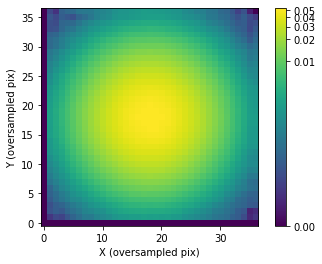

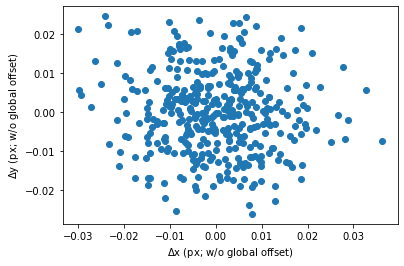

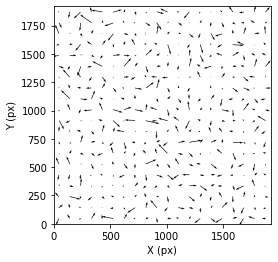

Analyzing image.12.0.01.fits...


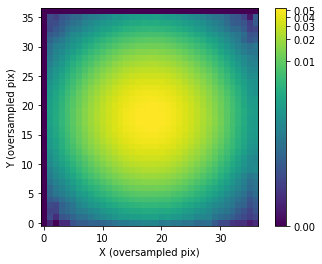

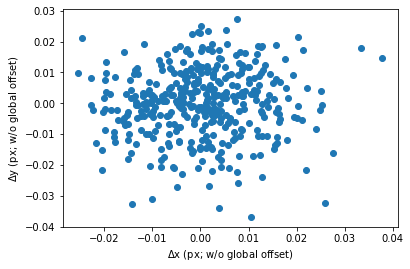

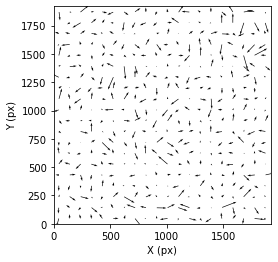

Analyzing image.12.0.02.fits...


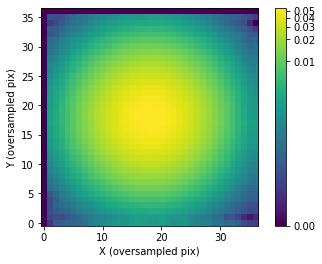

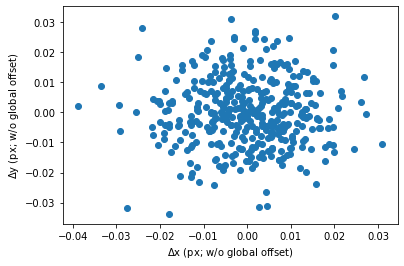

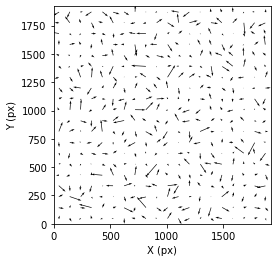

Analyzing image.12.0.03.fits...


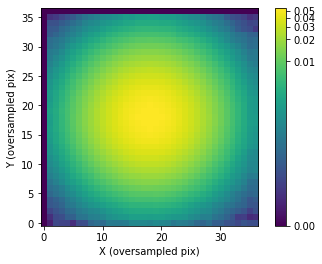

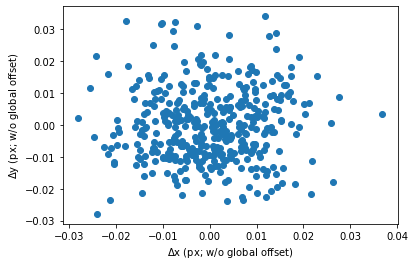

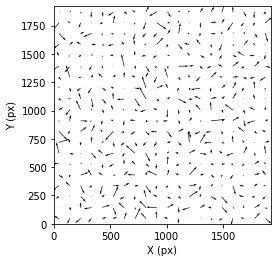

Analyzing image.12.0.04.fits...


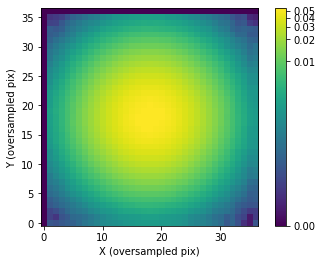

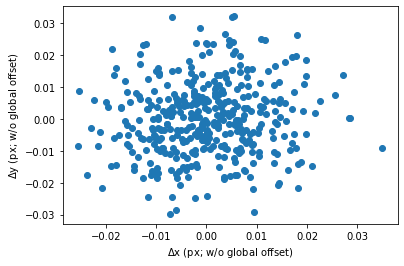

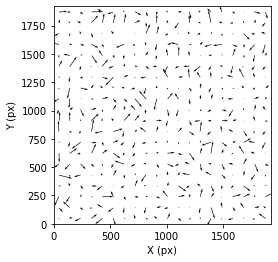

Analyzing image.12.0.05.fits...


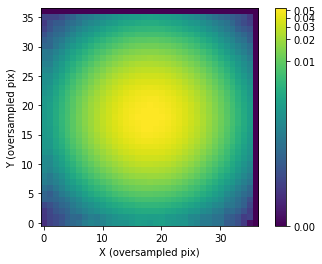

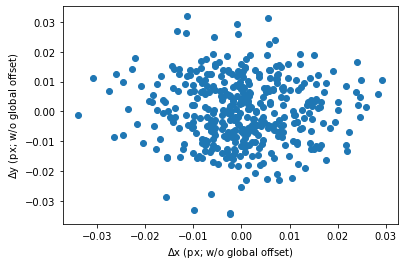

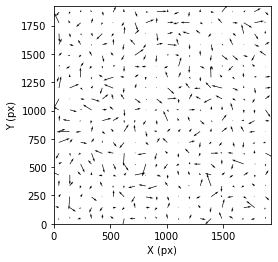

Analyzing image.12.0.06.fits...


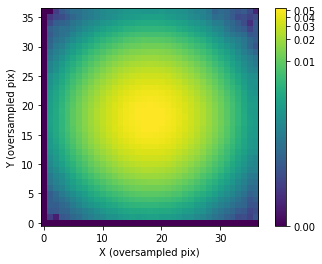

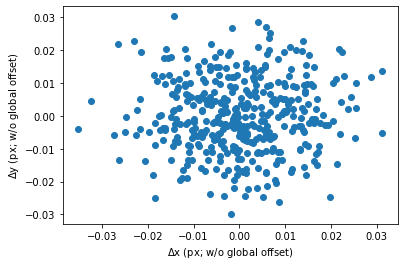

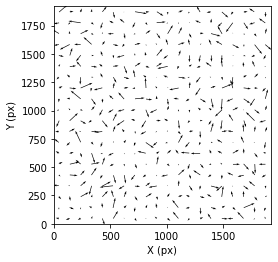

Analyzing image.12.0.07.fits...


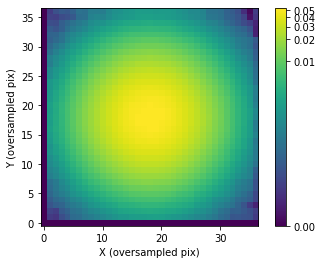

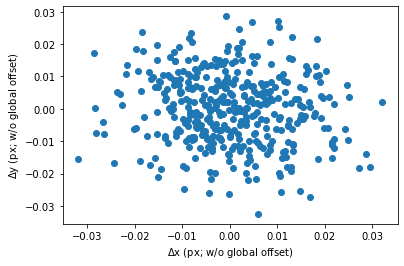

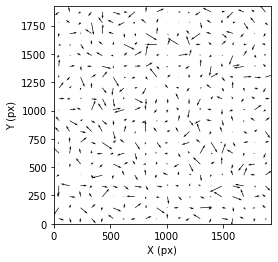

Analyzing image.12.0.08.fits...


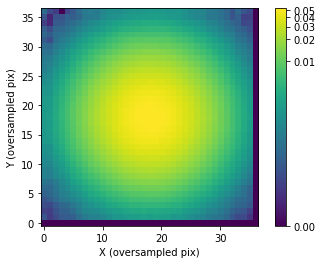

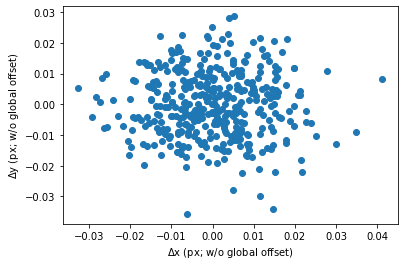

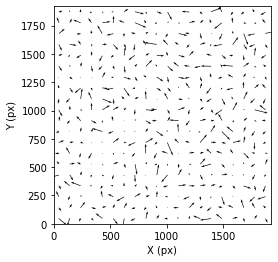

Analyzing image.12.0.09.fits...


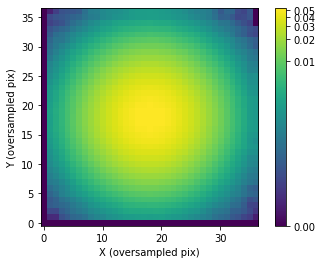

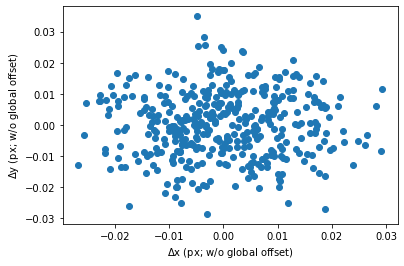

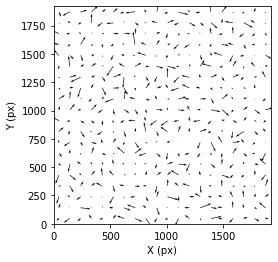

Analyzing image.12.0.10.fits...


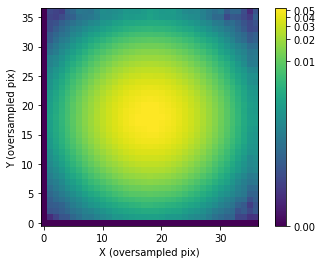

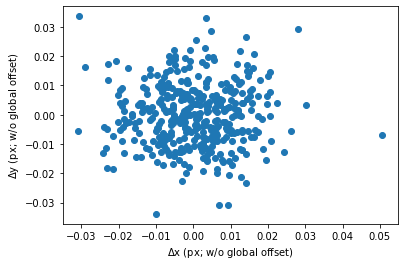

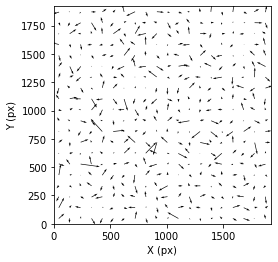

Analyzing image.12.5.00.fits...


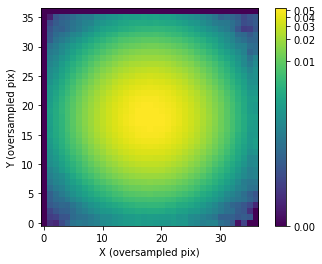

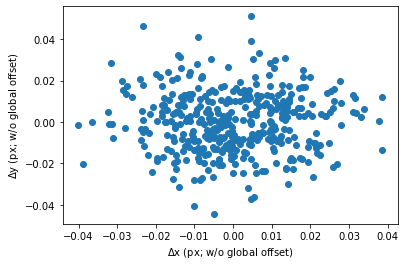

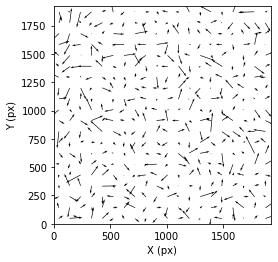

Analyzing image.12.5.01.fits...


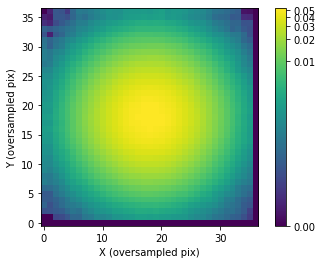

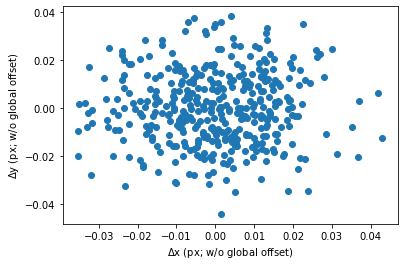

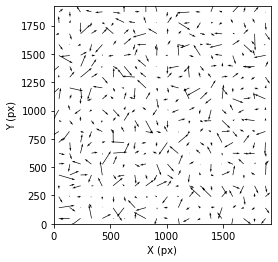

Analyzing image.12.5.02.fits...


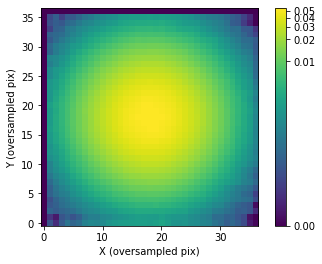

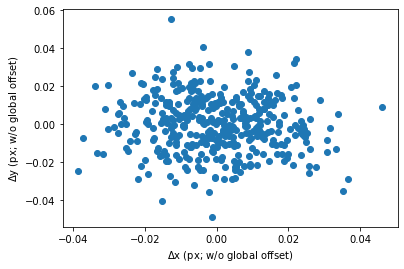

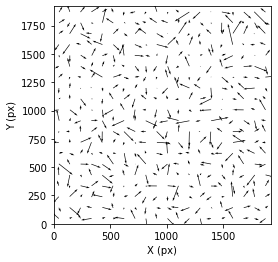

Analyzing image.12.5.03.fits...


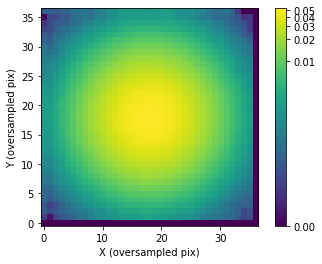

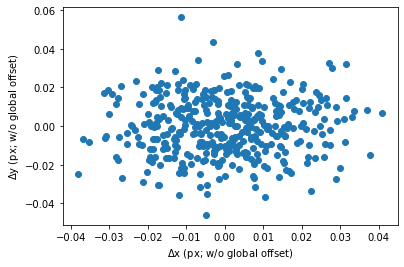

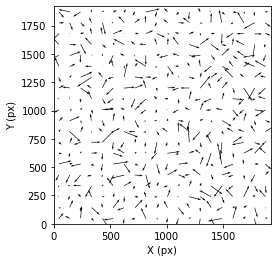

Analyzing image.12.5.04.fits...


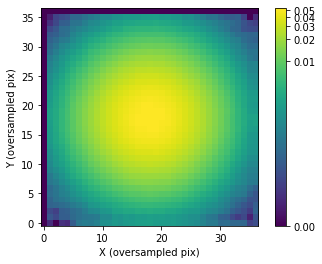

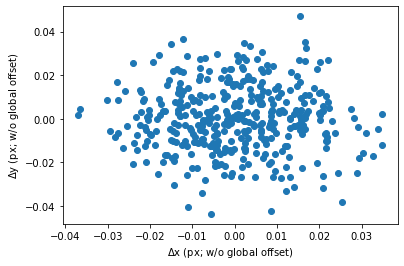

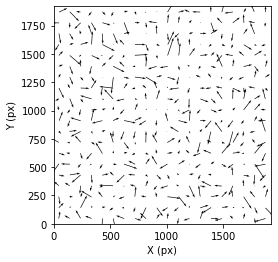

Analyzing image.12.5.05.fits...


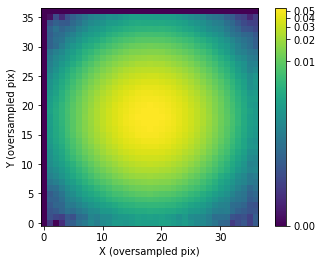

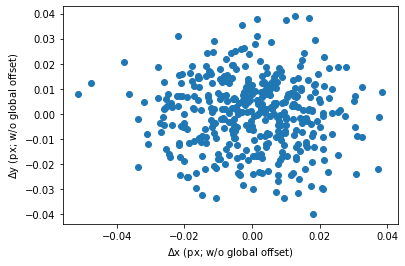

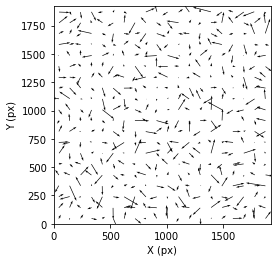

Analyzing image.12.5.06.fits...


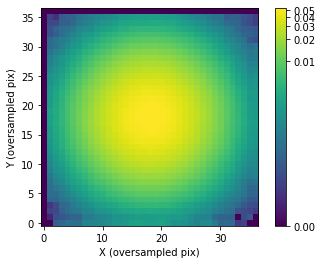

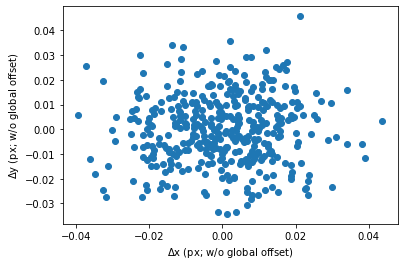

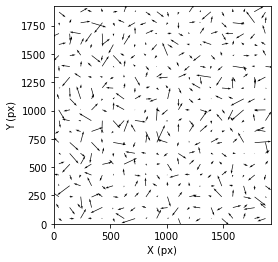

Analyzing image.12.5.07.fits...


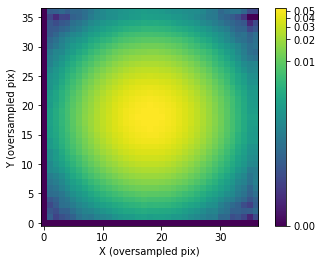

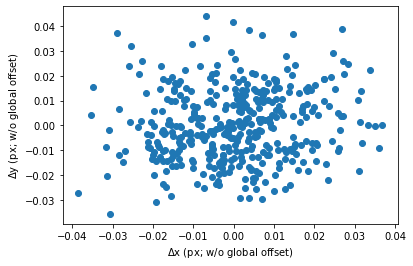

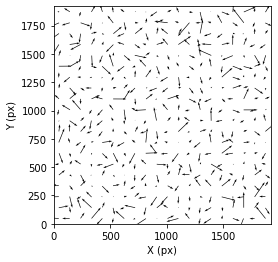

Analyzing image.12.5.08.fits...


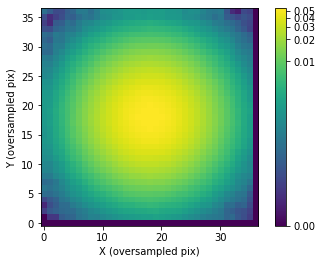

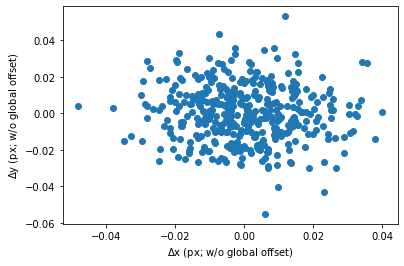

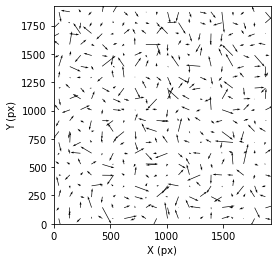

Analyzing image.12.5.09.fits...


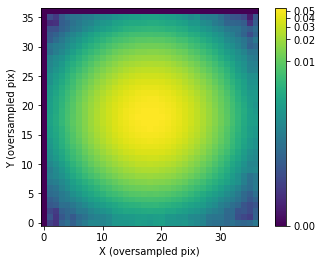

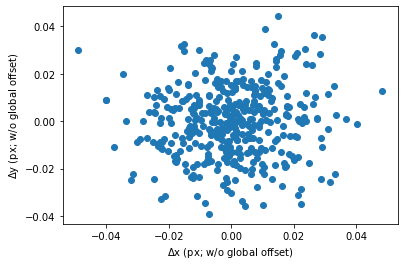

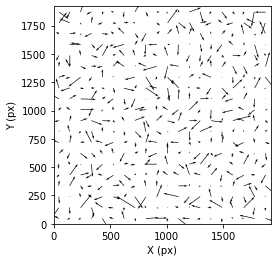

Analyzing image.12.5.10.fits...


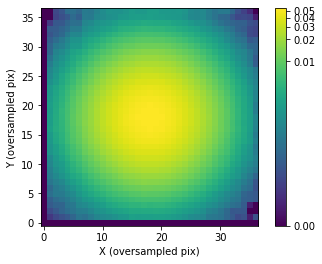

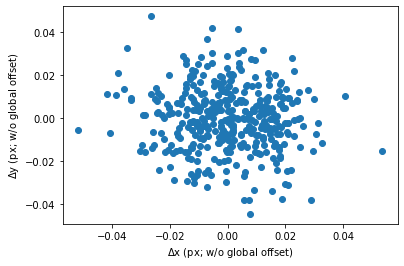

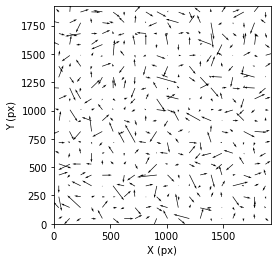

Analyzing image.13.0.00.fits...


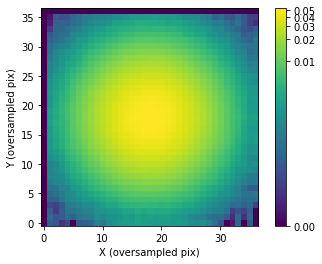

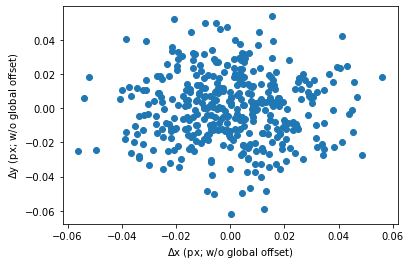

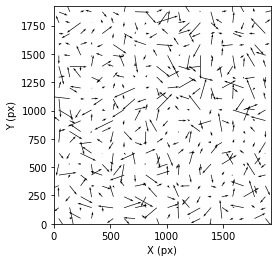

Analyzing image.13.0.01.fits...


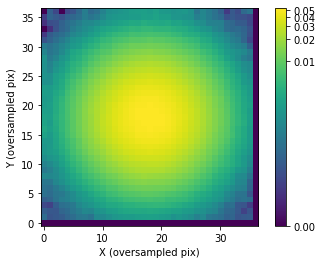

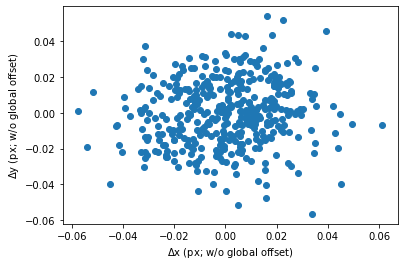

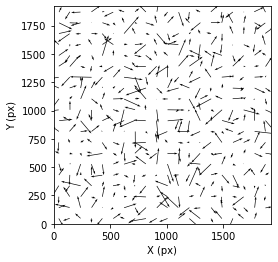

Analyzing image.13.0.02.fits...


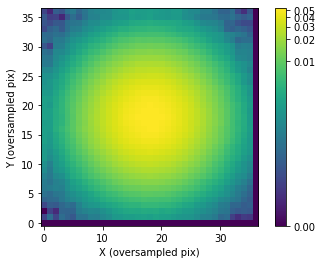

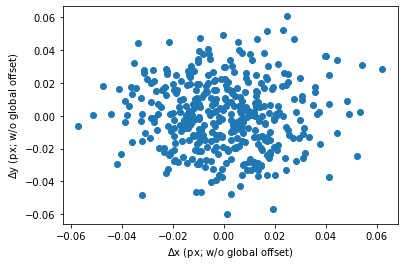

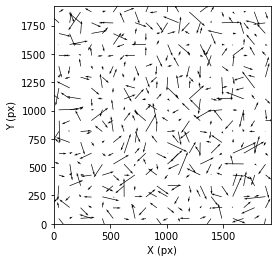

Analyzing image.13.0.03.fits...


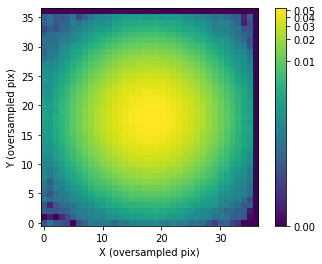

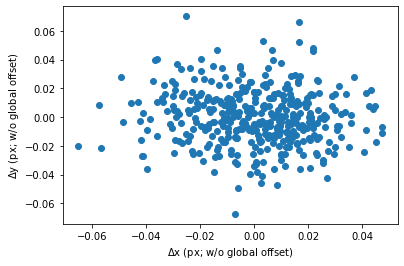

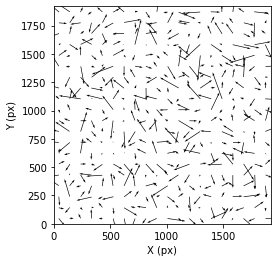

Analyzing image.13.0.04.fits...


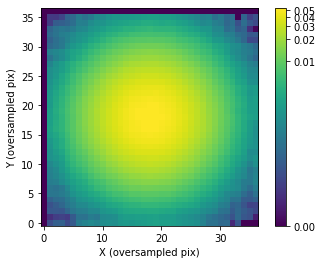

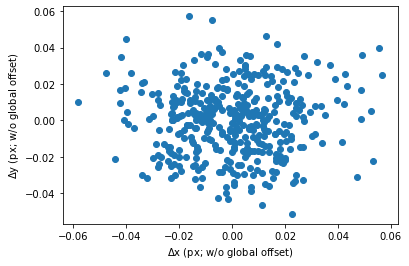

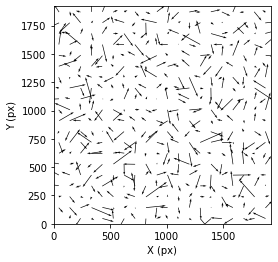

Analyzing image.13.0.05.fits...


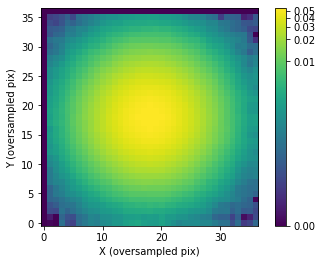

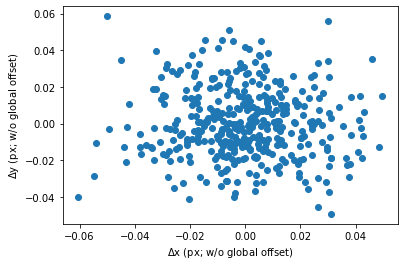

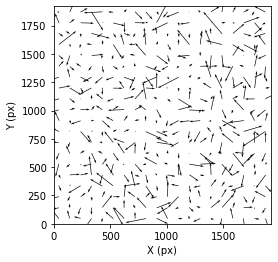

Analyzing image.13.0.06.fits...


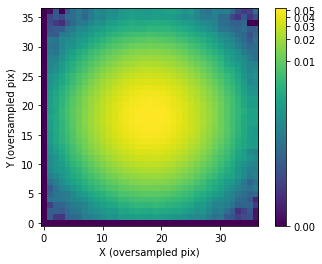

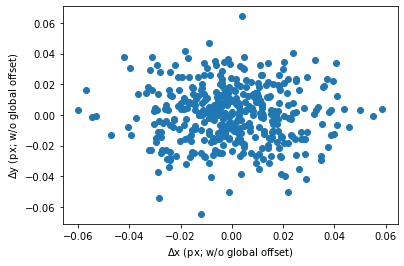

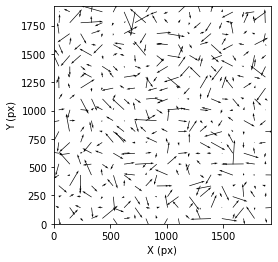

Analyzing image.13.0.07.fits...


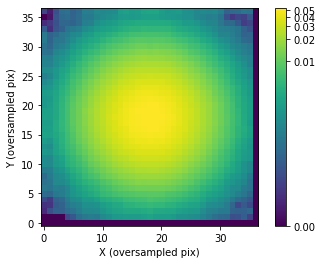

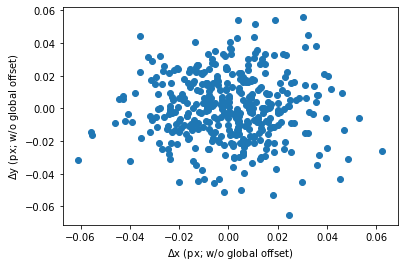

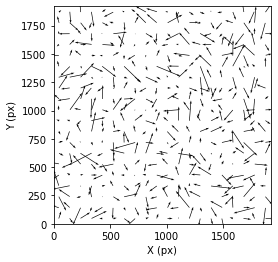

Analyzing image.13.0.08.fits...


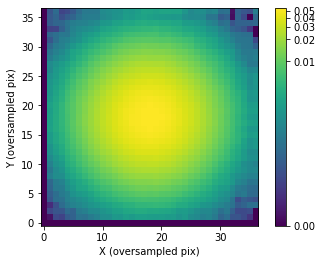

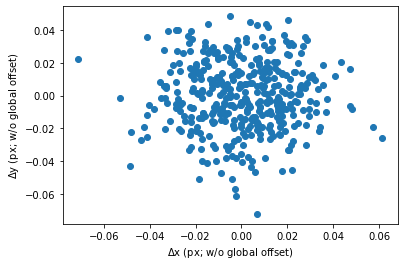

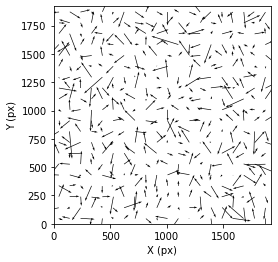

Analyzing image.13.0.09.fits...


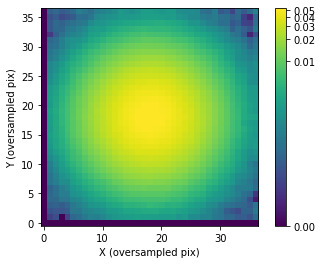

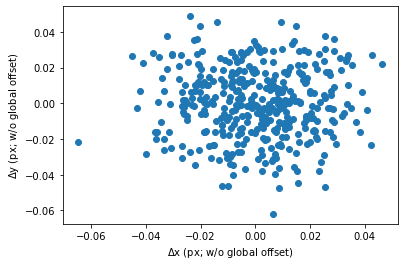

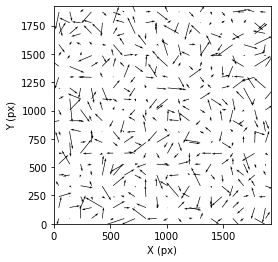

Analyzing image.13.0.10.fits...


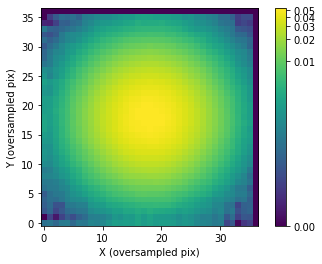

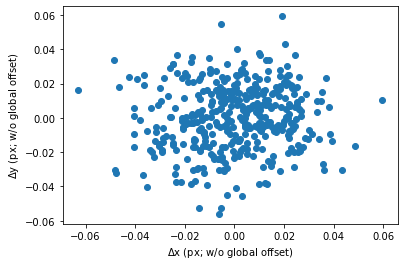

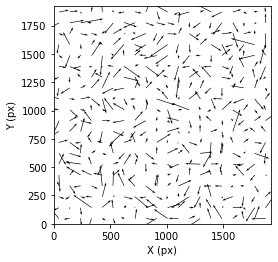

Analyzing image.13.5.00.fits...


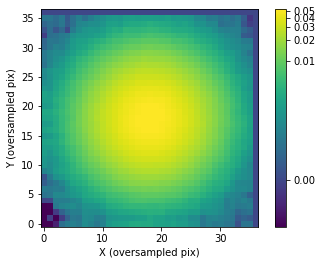

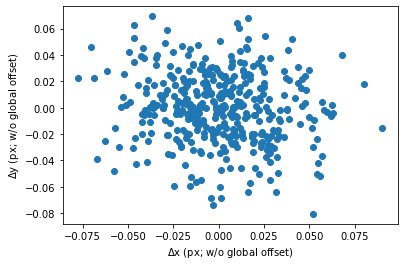

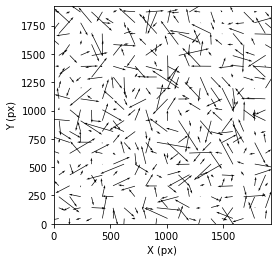

Analyzing image.13.5.01.fits...


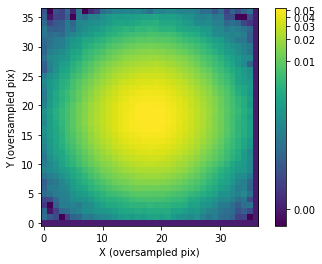

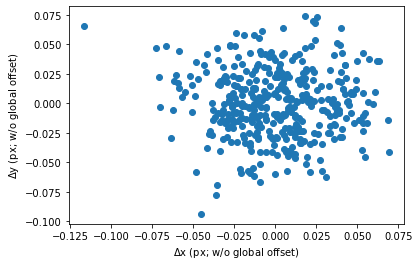

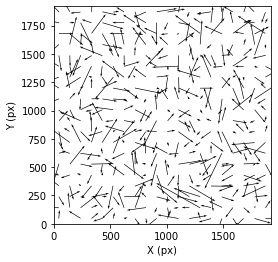

Analyzing image.13.5.02.fits...


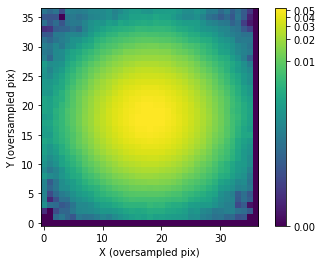

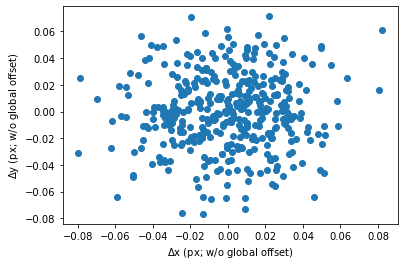

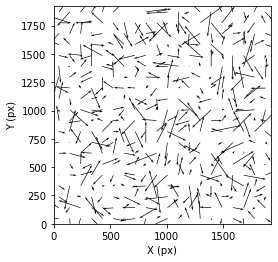

Analyzing image.13.5.03.fits...


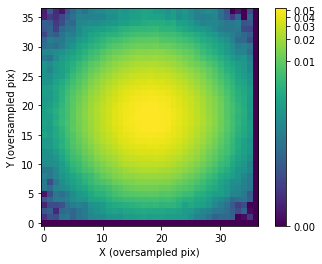

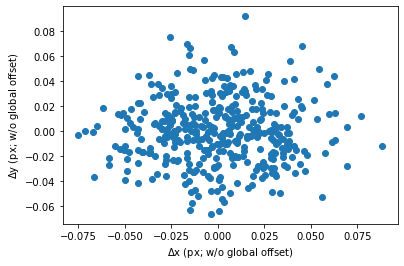

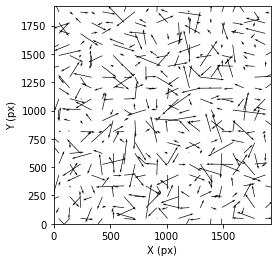

Analyzing image.13.5.04.fits...


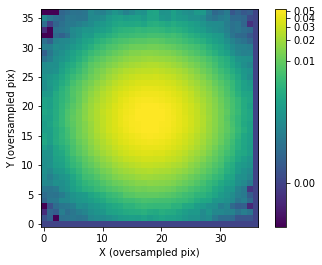

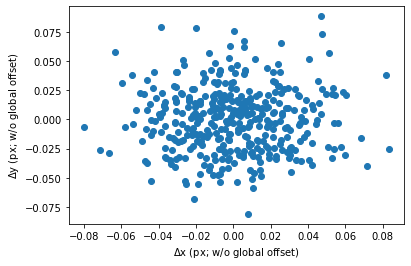

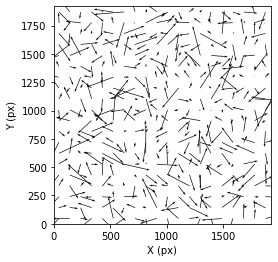

Analyzing image.13.5.05.fits...


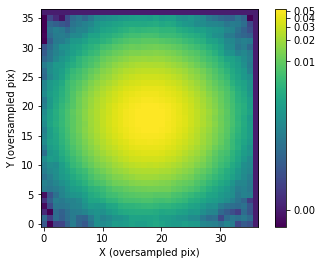

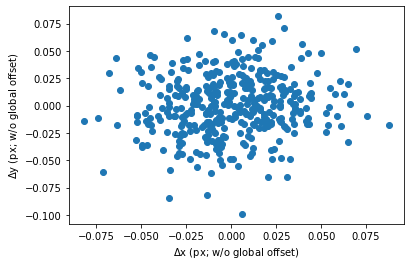

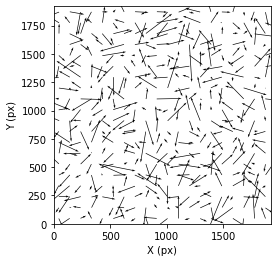

Analyzing image.13.5.06.fits...


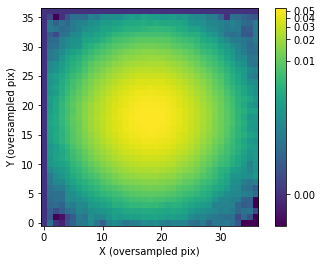

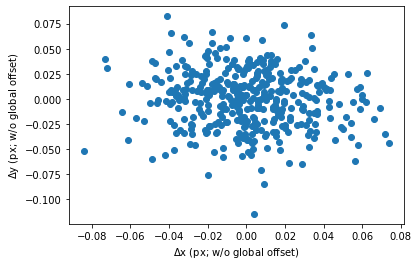

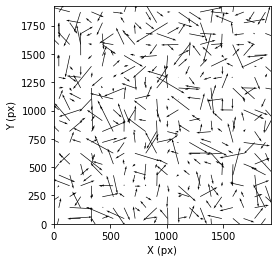

Analyzing image.13.5.07.fits...


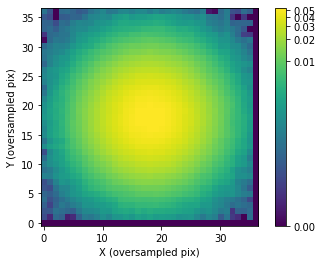

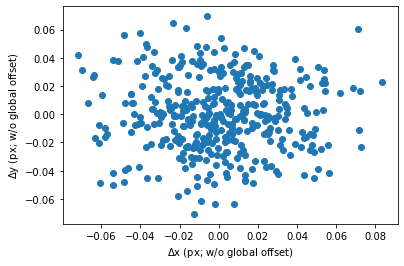

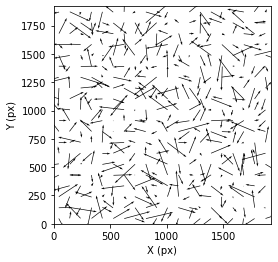

Analyzing image.13.5.08.fits...


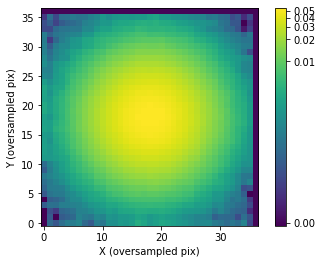

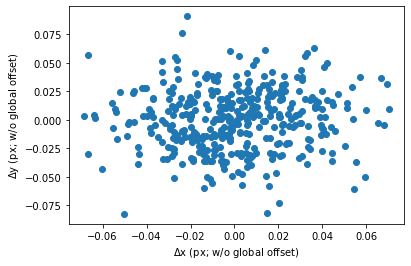

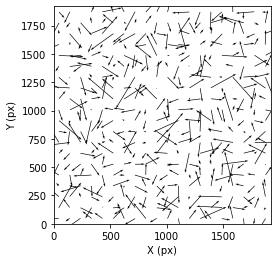

Analyzing image.13.5.09.fits...


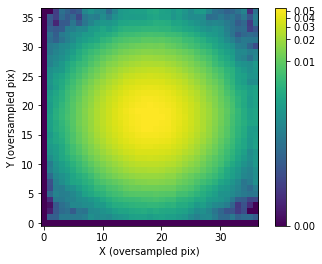

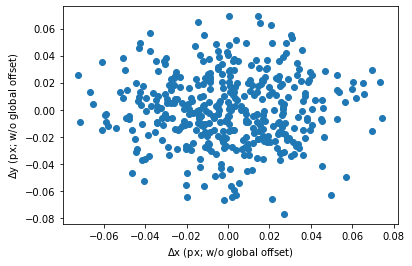

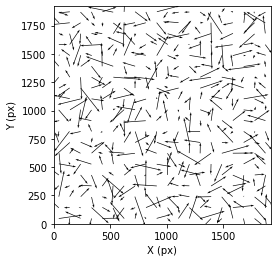

Analyzing image.13.5.10.fits...


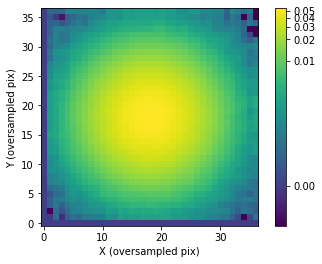

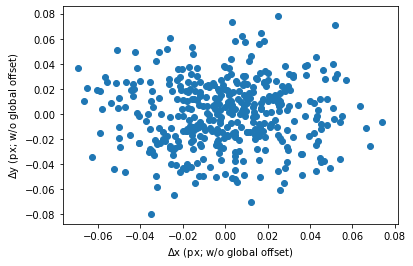

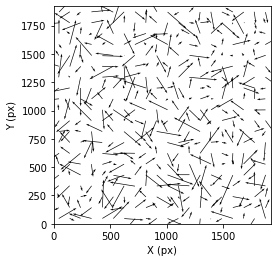

Analyzing image.14.0.00.fits...


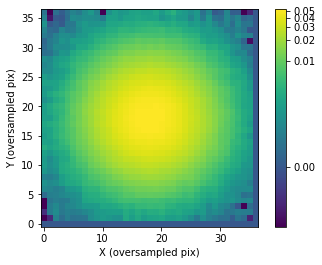

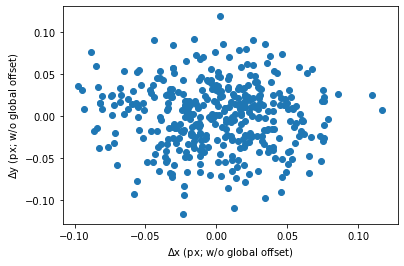

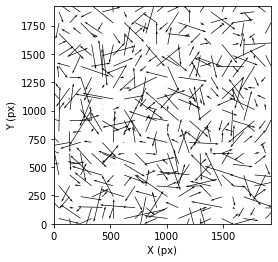

Analyzing image.14.0.01.fits...


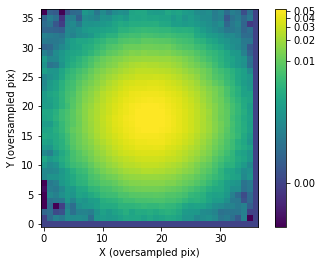

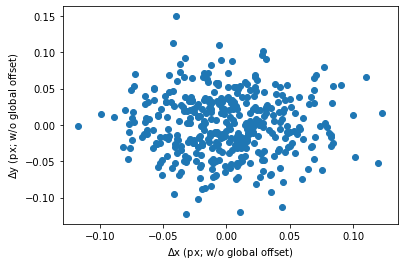

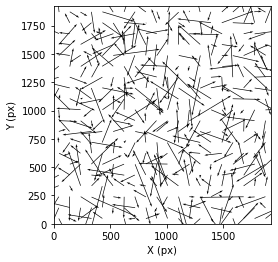

Analyzing image.14.0.02.fits...


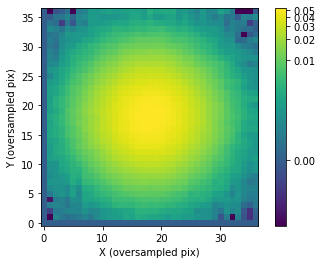

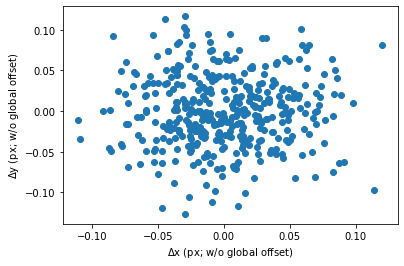

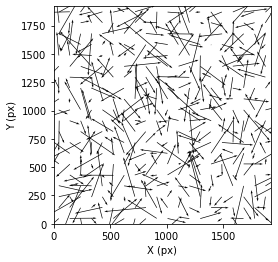

Analyzing image.14.0.03.fits...


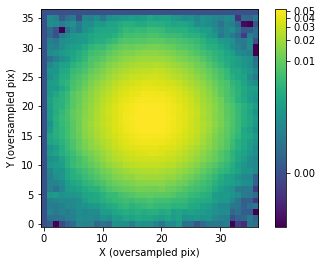

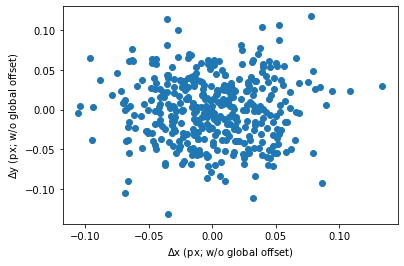

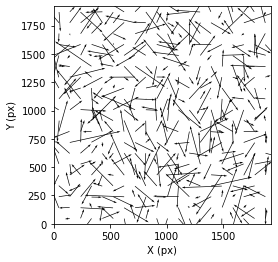

Analyzing image.14.0.04.fits...


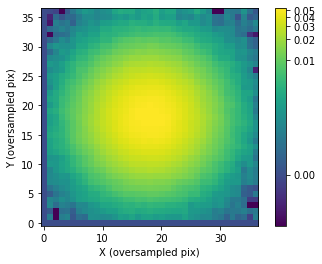

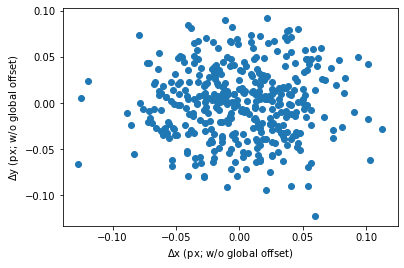

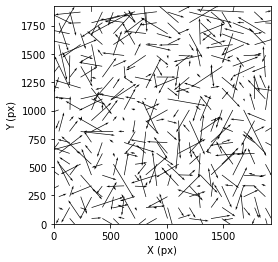

Analyzing image.14.0.05.fits...


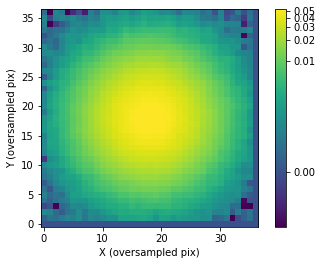

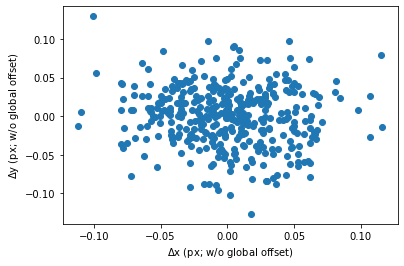

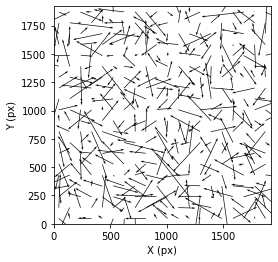

Analyzing image.14.0.06.fits...


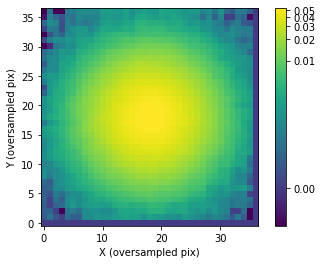

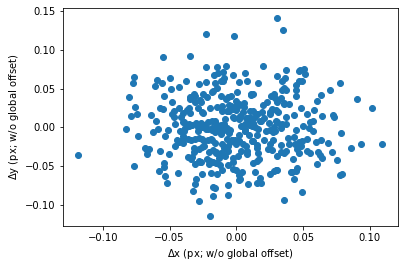

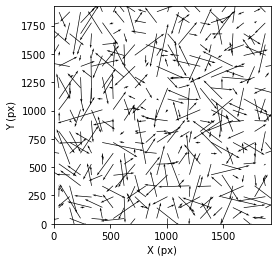

Analyzing image.14.0.07.fits...


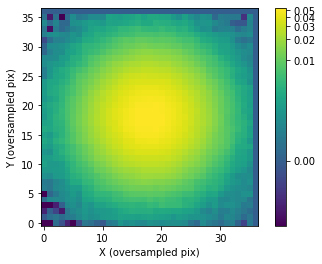

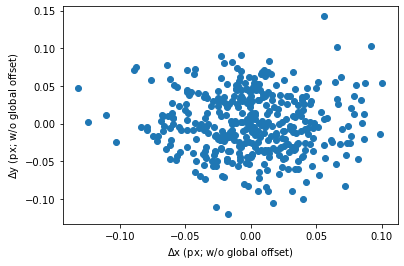

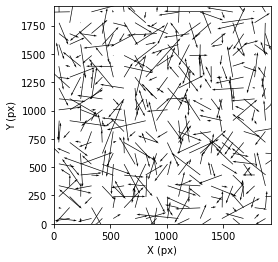

Analyzing image.14.0.08.fits...


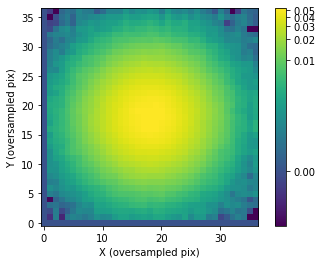

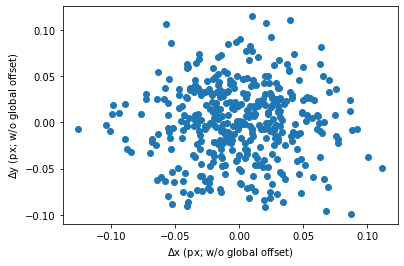

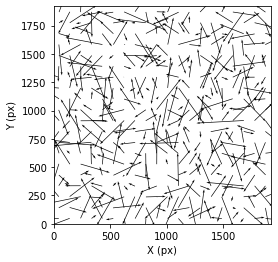

Analyzing image.14.0.09.fits...


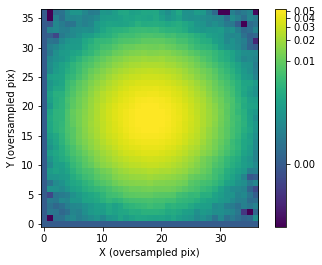

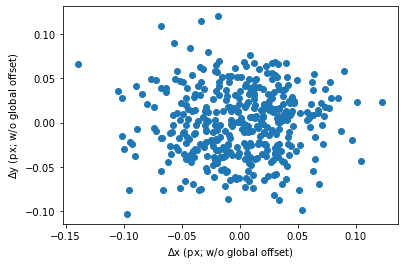

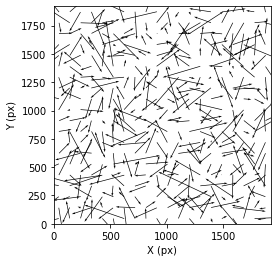

Analyzing image.14.0.10.fits...


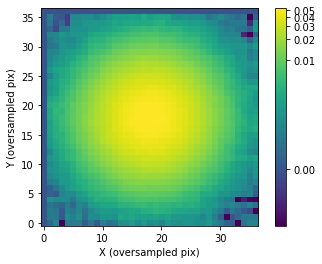

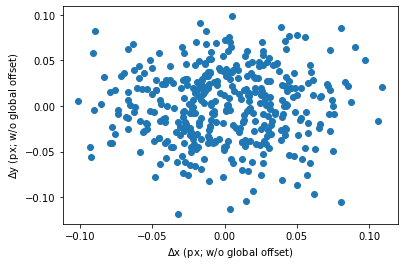

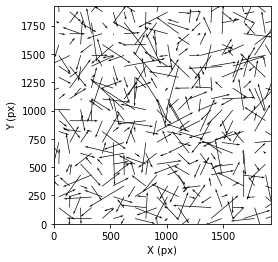

Analyzing image.14.5.00.fits...


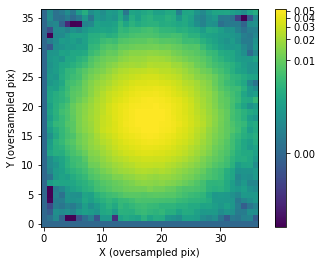

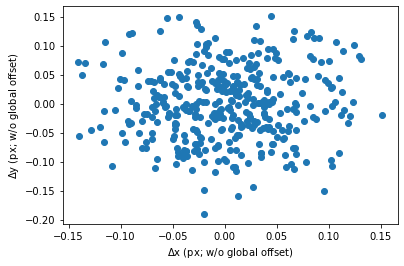

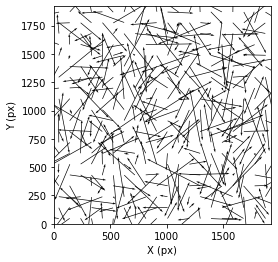

Analyzing image.14.5.01.fits...


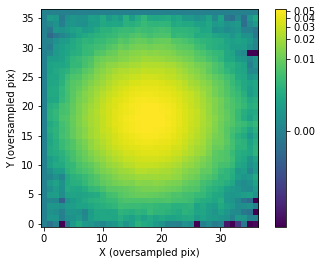

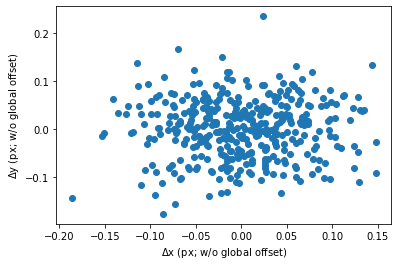

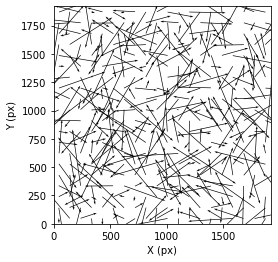

Analyzing image.14.5.02.fits...


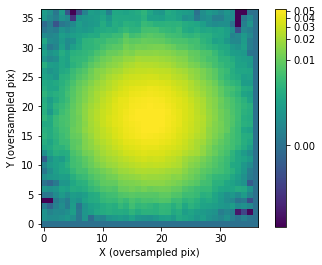

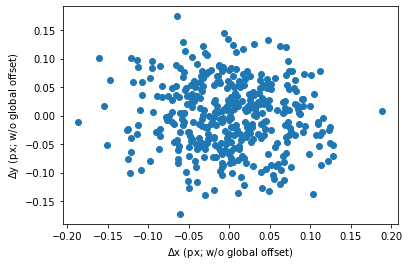

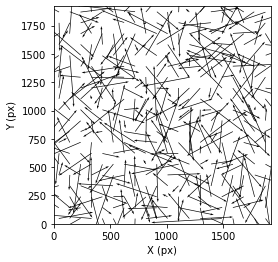

Analyzing image.14.5.03.fits...


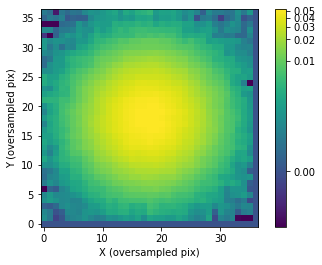

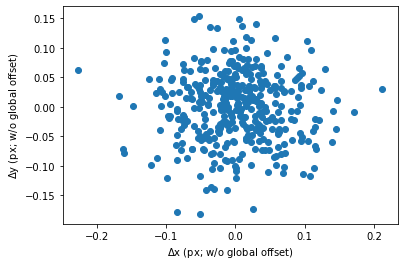

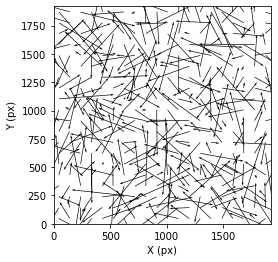

Analyzing image.14.5.04.fits...


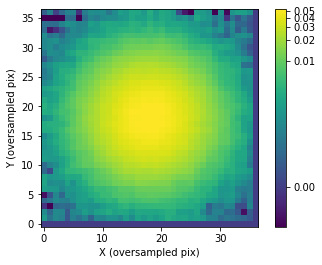

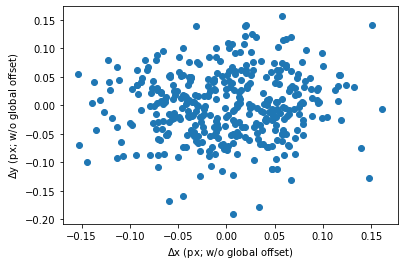

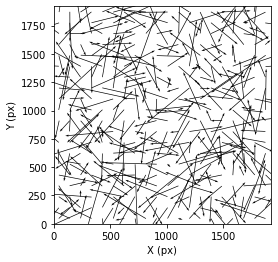

Analyzing image.14.5.05.fits...


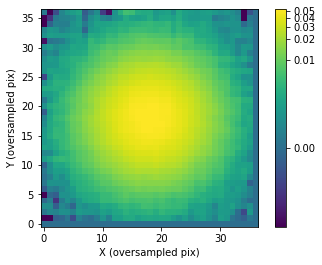

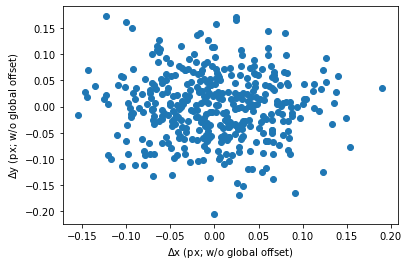

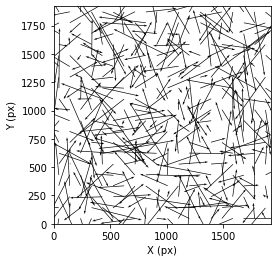

Analyzing image.14.5.06.fits...


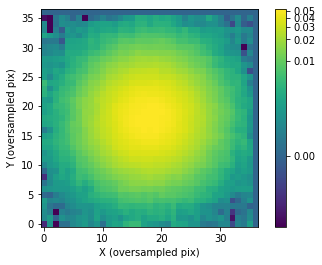

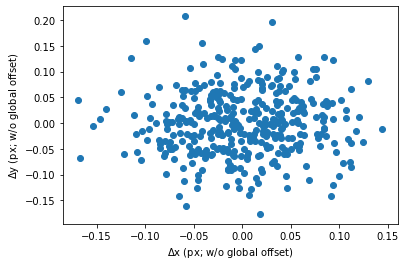

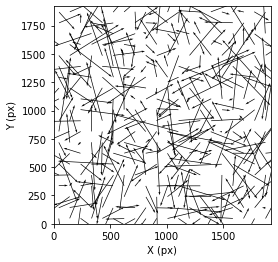

Analyzing image.14.5.07.fits...


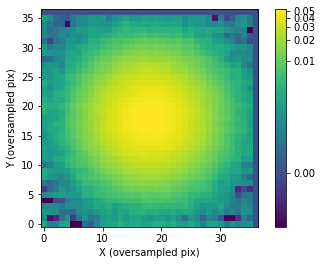

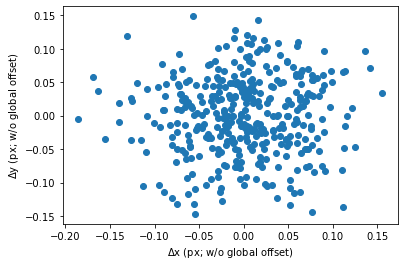

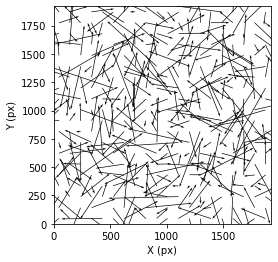

Analyzing image.14.5.08.fits...


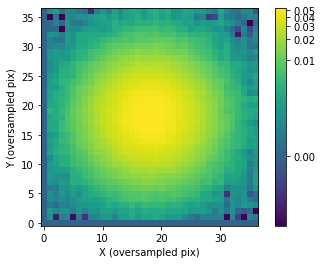

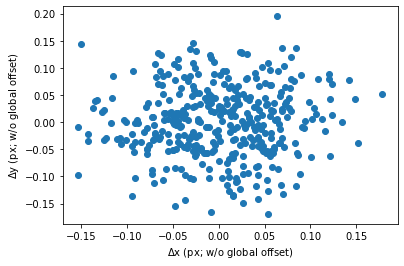

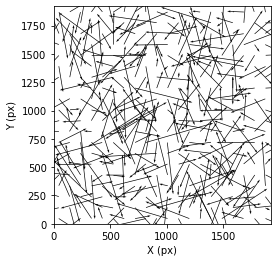

Analyzing image.14.5.09.fits...


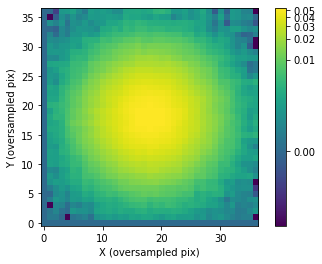

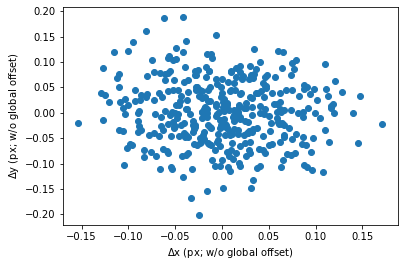

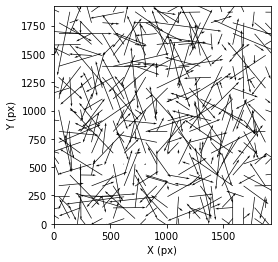

Analyzing image.14.5.10.fits...


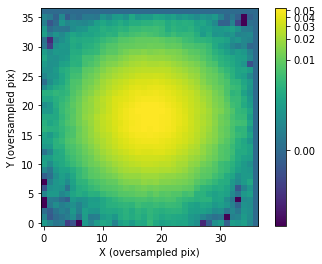

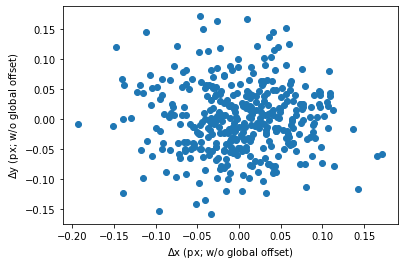

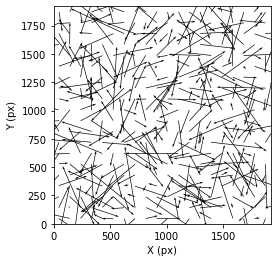

In [3]:
sra=[]
for mag in np.arange(12.0,15.0,0.5):
    tmp = []
    for i in range(0,11):
        sx, sy, sr = func("image.{:4.1f}.{:02d}.fits".format(mag,i),
                          "../01_params/spcsv_20_1920_10_20_12.0.csv")
        tmp.append(sr)
    sra.append(tmp)
sra = np.array(sra)

In [4]:
mags = np.arange(12.0,15.0,0.5)

Accuracy at 12.0 mag: 0.00719 p/m 0.00006 px
Accuracy at 12.5 mag: 0.00953 p/m 0.00011 px
Accuracy at 13.0 mag: 0.01274 p/m 0.00015 px
Accuracy at 13.5 mag: 0.01799 p/m 0.00015 px
Accuracy at 14.0 mag: 0.02577 p/m 0.00028 px
Accuracy at 14.5 mag: 0.03877 p/m 0.00040 px


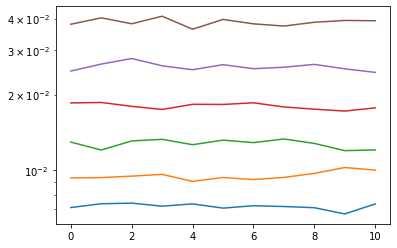

In [5]:
srs = []
for i in range(6):
    print("Accuracy at {:4.1f} mag: {:7.5f} p/m {:7.5f} px".format(mags[i], np.mean(sra[i]),
                                                np.std(sra[i],ddof=1)/np.sqrt(np.size(sra[i]))))
    srs.append([mags[i], np.mean(sra[i]), np.std(sra[i],ddof=1)/np.sqrt(np.size(sra[i]))])
    plt.plot(sra[i],label='{:4.1f} mag'.format(mags[i]))
plt.yscale('log')
plt.show()
srs = np.array(srs)

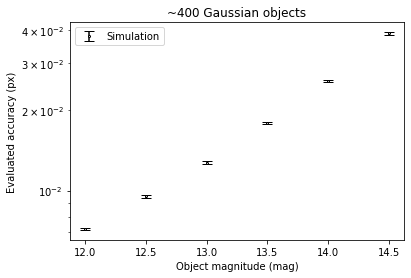

In [6]:
plt.errorbar(srs[:,0], srs[:,1], yerr=srs[:,2], capsize=5, fmt='o', markersize=2, 
             ecolor='black', markeredgecolor = "black", color='w', label='Simulation')
plt.yscale('log')
plt.xlabel('Object magnitude (mag)')
plt.ylabel('Evaluated accuracy (px)')
plt.title('~400 Gaussian objects')
plt.legend()
plt.show()